In [1]:
# Import statements
import urllib
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
from dateutil.parser import parse
from dateutil import parser
from collections import defaultdict
import re
import pickle
import os
import pandas as pd
import numpy as np

In [2]:
from urllib.error import URLError

def soupify(url):
    if url[:8] != 'https://':
        url = 'https://'+url
        
    try:
        req = urllib.request.Request(url, headers={'User-Agent' : "Magic Browser"}) 
        con = urllib.request.urlopen( req )
        html = con.read()
        soup = BeautifulSoup(html,'html.parser')
        return soup
    except URLError:
        return None

# Contents:
* [Get URLs](#Get-URLs)
    * [Climate change](#Climate-change)
        * [URLs from search](#URLs-from-search)
        * [MediaCloud URLs](#MediaCloud-urls)
        * [Reid Google search URLs](#Reid-Urls)
    * [Vaccines](#Vaccines)
* [Post-processing](#Post-processing)
    * [Filter out non-(relevant)-article URLs](#Filter-out-non-(relevant)-article-URLs)
    * [Check consistency of coding](#Check-consistency-of-coding)
    * [Deduplicate](#Dedup)
* [Scraping fulltext and missing meta info](#Scraping-fulltext-and-missing-meta-info)
    * [Filter empty fulltext articles](#Filter-out-URLs-that-don't-have-article-text)
* [Dedup via title similarity](#Dedup-via-title-similarity)
* [Summary stats](#Summary-stats)

# Get URLs

We use SerpApi (https://serpapi.com/search-api) to scrape Google search results from querying climate change-related keywords on various websites.

In [58]:
SERP_API_KEY = "481df24348cbec5d00f65baa55986d30b3b1ef2b09c5ab9de0f667dd43ce51d2"
from serpapi.google_search_results import GoogleSearchResults

The following query parameters restrict searches to desktop, US-based, English-language results:

In [60]:
query_params = {"location":"United States", "device":"desktop", "hl":"en", "gl":"us", "serp_api_key":SERP_API_KEY}
client = GoogleSearchResults(query_params)

In [224]:
def do_serpapi(domain,keyword):
    keyword = keyword.replace('_',' ').replace('+',' ').replace('-',' ')
    client.params_dict["q"] = "site:{} {}".format(domain,keyword) # Update query to restrict to particular site
    print('Searching w/ query: {}...'.format(client.params_dict["q"]))
    page_no = 1 
    client.params_dict["start"] = (page_no-1)*10                  # Update pagination
    
    dict_list = []
    while 'error' not in client.get_dict(): # Get results as long as more pages exist
        dict_list.append(client.get_dict())
        page_no += 1
        client.params_dict["start"] = (page_no-1)*10 
    
    return dict_list

In [234]:
def parse_serpapi_results(d_list):
    meta = []
    for d in d_list:
        if 'error' in d:
            print(d['error'])
        elif d['search_metadata']['status'] == 'Success':
            res = d['organic_results']
            page_no = d['search_information']['page_number'] if 'page_number' in d['search_information'] else 1
            print('Number of results on page {}: {}'.format(page_no,len(res)))
            meta.extend([(x['title'],x['link'],x['date']) if 'date' in x
                        else (x['title'],x['link']) for x in res])
        else:
            print("API get failure")
    return meta

## Climate change

In [239]:
# Keywords to use for climate change searches
CC_KEYWORDS = ['climate_change','global_warming','fossil_fuels','carbon_dioxide','co2']

The below 3 sections generate the following data structures:
    * google_search_res_climate_change.pkl, a dictionary with outer keys for domains and inner keys for search terms;
    * mediacloud_df.pkl, a dataframe w/ output from MediaCloud;
    * reid_urls, a dictionary with urls from each of 6 domains searched via Google by Reid

### URLs from search

In [202]:
# Initialize default nested dict with outer keys for each media domain and inner keys for each keyword.
#URLS_PER_DOMAIN = defaultdict(dict)

In [108]:
# Domains to search for climate change articles
DOMAINS = ['www.foxnews.com','www.breitbart.com','www.theblaze.com','www.pjmedia.com','www.nationalreview.com',
           'www.thenation.com','www.buzzfeednews.com','www.vox.com','www.washingtonpost.com','www.progressive.org',
          'www.nytimes.com','www.motherjones.com','www.democracynow.org']

In [235]:
# Query each domain for each keyword
for DOMAIN in DOMAINS:
    for KW in CC_KEYWORDS:
        dl = do_serpapi(DOMAIN,KW)
        results = parse_serpapi_results(dl)
        URLS_PER_DOMAIN[DOMAIN][KW] = results

Searching w/ query: site:www.theblaze.com climate change...
Number of results on page 1: 10
Number of results on page 2: 10
Number of results on page 3: 10
Number of results on page 4: 10
Number of results on page 5: 10
Number of results on page 6: 10
Number of results on page 7: 10
Number of results on page 8: 10
Number of results on page 9: 10
Number of results on page 10: 10
Number of results on page 11: 10
Number of results on page 12: 10
Number of results on page 13: 10
Number of results on page 14: 10
Number of results on page 15: 10
Number of results on page 16: 10
Number of results on page 17: 10
Number of results on page 18: 10
Number of results on page 19: 10
Number of results on page 20: 10
Number of results on page 21: 10
Number of results on page 22: 10
Number of results on page 23: 10
Number of results on page 24: 10
Number of results on page 25: 10
Number of results on page 26: 10
Number of results on page 27: 10
Number of results on page 28: 10
Number of results on page

Number of results on page 1: 10
Number of results on page 2: 10
Number of results on page 3: 10
Number of results on page 4: 10
Number of results on page 5: 10
Number of results on page 6: 10
Number of results on page 7: 10
Number of results on page 8: 10
Number of results on page 9: 9
Number of results on page 10: 10
Number of results on page 11: 10
Number of results on page 12: 10
Number of results on page 13: 10
Number of results on page 14: 10
Number of results on page 15: 10
Number of results on page 16: 10
Number of results on page 17: 10
Number of results on page 18: 10
Number of results on page 19: 10
Number of results on page 20: 10
Number of results on page 21: 10
Number of results on page 22: 10
Number of results on page 23: 10
Number of results on page 24: 10
Number of results on page 25: 10
Number of results on page 26: 10
Number of results on page 27: 10
Number of results on page 28: 1
Searching w/ query: site:www.buzzfeednews.com climate change...
Number of results on pa

Number of results on page 1: 10
Number of results on page 2: 10
Number of results on page 3: 10
Number of results on page 4: 10
Number of results on page 5: 10
Number of results on page 6: 10
Number of results on page 7: 10
Number of results on page 8: 10
Number of results on page 9: 10
Number of results on page 10: 10
Number of results on page 11: 10
Number of results on page 12: 10
Number of results on page 13: 10
Number of results on page 14: 10
Number of results on page 15: 10
Number of results on page 16: 10
Number of results on page 17: 10
Number of results on page 18: 10
Number of results on page 19: 10
Number of results on page 20: 10
Number of results on page 21: 10
Number of results on page 22: 10
Number of results on page 23: 10
Number of results on page 24: 10
Number of results on page 25: 10
Number of results on page 26: 10
Number of results on page 27: 10
Number of results on page 28: 10
Number of results on page 29: 10
Number of results on page 30: 10
Number of results o

Number of results on page 1: 10
Number of results on page 2: 10
Number of results on page 3: 9
Number of results on page 4: 10
Number of results on page 5: 10
Number of results on page 6: 10
Number of results on page 7: 10
Number of results on page 8: 10
Number of results on page 9: 10
Number of results on page 10: 10
Number of results on page 11: 10
Number of results on page 12: 10
Number of results on page 13: 10
Number of results on page 14: 10
Number of results on page 15: 10
Number of results on page 16: 10
Number of results on page 17: 10
Number of results on page 18: 10
Number of results on page 19: 10
Number of results on page 20: 10
Number of results on page 21: 10
Number of results on page 22: 10
Number of results on page 23: 10
Number of results on page 24: 10
Number of results on page 25: 10
Number of results on page 26: 10
Number of results on page 27: 10
Number of results on page 28: 3
Searching w/ query: site:www.democracynow.org climate change...
Number of results on pa

In [241]:
# Save nested dict
pickle.dump(URLS_PER_DOMAIN,open('google_search_res_climate_change.pkl','wb'))

In [242]:
URLS_PER_DOMAIN.keys()

dict_keys(['www.foxnews.com', 'www.breitbart.com', 'www.theblaze.com', 'www.pjmedia.com', 'www.nationalreview.com', 'www.thenation.com', 'www.buzzfeednews.com', 'www.vox.com', 'www.washingtonpost.com', 'www.progressive.org', 'www.nytimes.com', 'www.motherjones.com', 'www.democracynow.org'])

### MediaCloud URLs

We use the MediaCloud Python client (https://github.com/mitmedialab/MediaCloud-API-Client) to fetch stories from a larger set of media outlets.

In [244]:
import datetime
import mediacloud.api
mc = mediacloud.api.MediaCloud('feb32a16d870132da7e7d93a0414d796fec95edd30a55d453075927d083a807b')

These are the fields that we're interested in getting:

In [245]:
mc_metadata = ['ap_syndicated','language','media_id','media_name','publish_date','title','guid','url','word_count']

Read in tab-separated file with outlet id and stance information.

In [282]:
mc_ids = pd.read_csv('mediacloud_ids.txt',sep='\t',header=None)
mc_ids.columns=['id','outlet_name','stance']
mc_ids.head()

,id,outlet_name,stance
0,1,new_york_times,pro
1,2,washington_post,pro
2,3,christian_science_monitor,between
3,4,usa_today,pro
4,1092,fox,anti


In [273]:
# Collect stories from each outlet
for curr_outlet_ix in mc_ids.index:
    curr_outlet_id = mc_ids.iloc[curr_outlet_ix]['id']
    curr_outlet_stance = mc_ids.iloc[curr_outlet_ix]['stance']
    fetch_size = 500
    stories = []
    last_processed_stories_id = 0
    for start_year in range(2000,2021,5): # Start collecting stories from Jan. 1, 2000 
        while len(stories) < 2000:
            fetched_stories = mc.storyList('(climate AND chang*) OR (global AND warming) OR (carbon AND dioxide) OR (co2) AND media_id:{}'.format(curr_outlet_id), 
                                           solr_filter=mc.publish_date_query(datetime.date(start_year,1,1), datetime.date(start_year+4,12,31)),
                                           last_processed_stories_id=last_processed_stories_id, rows= fetch_size)
            stories.extend(fetched_stories)
            if len( fetched_stories) < fetch_size:
                break
            last_processed_stories_id = stories[-1]['processed_stories_id']
    if len(stories) > 0:
        df = pd.DataFrame({key: [s[key] for s in stories] for key in mc_metadata})
        df['topic'] = ['cc']*len(df)
        df['stance'] = curr_outlet_stance
        df.sort_values(by='publish_date')

        OUTLET_NAME = df['media_name'].iloc[0].lower().replace(' ','_')
        df.to_pickle(os.path.join('mediacloud','{}_df.pkl'.format(OUTLET_NAME)))
        print('Done fetching stories from {} (outlet id = {}).'.format(OUTLET_NAME,curr_outlet_id))

Done fetching stories from new_york_times (outlet id = 1).
Done fetching stories from washington_post (outlet id = 2).
Done fetching stories from christian_science_monitor (outlet id = 3).


Now, merge into a single df; filter out stories not in English; clean titles.

In [274]:
dfs = []
for filename in os.listdir('mediacloud'):
    df = pd.read_pickle(os.path.join('mediacloud',filename))
    dfs.append(df)
df_all = pd.concat(dfs,ignore_index=True)

In [275]:
df_all = df_all[df_all.language == 'en']
df_all['clean_title'] = df_all.title.apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x.lower()))

In [280]:
df_all

,ap_syndicated,language,media_id,media_name,publish_date,title,guid,url,word_count,topic,stance,clean_title
0,False,en,18468,activistpost.com,2011-05-28 17:32:00,Activist Post: David Cameron Says Non-Violent ...,http://www.activistpost.com/2014/09/david-came...,http://www.activistpost.com/2014/09/david-came...,None,cc,anti,activist post david cameron says nonviolent co...
1,False,en,18468,activistpost.com,2012-09-29 05:00:00,Activist Post: Is the CDC's Mandated Vaccine ...,http://www.activistpost.com/2012/09/is-cdcs-ma...,http://www.activistpost.com/2012/09/is-cdcs-ma...,None,cc,anti,activist post is the cdcs mandated vaccine sc...
2,False,en,18468,activistpost.com,2012-04-14 05:00:00,Activist Post: Haters of Humanity: The Church ...,http://www.activistpost.com/2012/04/haters-of-...,http://www.activistpost.com/2012/04/haters-of-...,None,cc,anti,activist post haters of humanity the church of...
3,False,en,18468,activistpost.com,2011-04-17 05:00:00,Activist Post: Masters Of The World Meet To Pl...,http://www.activistpost.com/2011/04/masters-of...,http://www.activistpost.com/2011/04/masters-of...,None,cc,anti,activist post masters of the world meet to pla...
4,False,en,18468,activistpost.com,2012-04-01 08:00:00,Is The CIA Manipulating the Weather?,https://www.activistpost.com/2016/07/is-the-ci...,https://www.activistpost.com/2016/07/is-the-ci...,None,cc,anti,is the cia manipulating the weather
...,...,...,...,...,...,...,...,...,...,...,...,...
10442,False,en,2,Washington Post,2020-02-23 19:53:13,The anti-Greta: A conservative think tank take...,https://www.washingtonpost.com/climate-environ...,https://www.washingtonpost.com/climate-environ...,None,cc,pro,the antigreta a conservative think tank takes ...
10443,False,en,2,Washington Post,2020-03-06 12:00:00,It was only a matter of time. Lab-created ‘mol...,https://www.washingtonpost.com/lifestyle/food/...,https://www.washingtonpost.com/lifestyle/food/...,None,cc,pro,it was only a matter of time labcreated molecu...
10444,False,en,2,Washington Post,2020-03-06 03:27:58,Global crises have spurred declines in emissio...,https://www.washingtonpost.com/climate-environ...,https://www.washingtonpost.com/climate-environ...,None,cc,pro,global crises have spurred declines in emissio...
10445,False,en,2,Washington Post,2020-03-09 07:56:07,The Energy 202: Three charts that explain what...,https://www.washingtonpost.com/politics/the-en...,https://www.washingtonpost.com/politics/the-en...,None,cc,pro,the energy 202 three charts that explain what ...


In [283]:
df_all[df_all.stance=='anti'].shape

(3407, 12)

In [284]:
df_all[df_all.stance=='pro'].shape

(6428, 12)

In [285]:
df_all.to_pickle('mediacloud_df.pkl')

### Reid URLs

In [287]:
reid_urls = {}

In [286]:
load_dir = '/Users/yiweiluo/Dropbox/research/QP2/reid_urls/'

In [289]:
for filename in os.listdir(load_dir):
    domain = '_'.join(filename.split('_')[:-1])
    urls = pd.read_csv(load_dir+filename,header=None)
    reid_urls[domain] = urls

In [290]:
reid_urls.keys()

dict_keys(['buzzfeed_news', 'democracy_now', 'the_nation', 'the_progressive', 'vox', 'washington_post'])

In [301]:
pickle.dump(reid_urls,open('reid_urls.pkl','wb'))

## Vaccines

This section will create a file ```temp_vax_blog_urls.pkl``` containing urls from each blog.

In [599]:
advocacy_blogs = ['https://www.voicesforvaccines.org/blog/',
                 'https://adultvaccinesnow.org/blog/',
                 'https://shotofprevention.com/',
                 'https://immunizationevidence.org/featured_issues/',
                 'https://www.nfid.org/blog/',
                 'https://vaxopedia.org/category/blog/',
                 'https://www.familiesfightingflu.org/insights-on-influenza/'
                 ]

Create datastructure to store post urls from each blog:

In [619]:
#blog_dict = defaultdict(list)

### Anti-vaccine blogs

Get URLs from each blog.

In [621]:
# Children's Health Defense
root_url = 'https://childrenshealthdefense.org/kennedy-news-views/page/'
for p_no in range(1,17):
    url = root_url + str(p_no)
    soup = soupify(url)
    articles = soup.find_all('section',attrs={"class":'knv-section'})
    urls_and_meta = []
    for art in articles:
        art_meta = art.find('figcaption').find('h4').find('a')
        art_date = art.find('figcaption').find('span').text.strip()
        art_title = art_meta.text.strip()
        art_url = art_meta['href']
        urls_and_meta.append((art_url,art_title,art_date))
    blog_dict['CHD'].extend(urls_and_meta)

In [660]:
# Vaccine Safety Commission
root_url = 'https://vaccinesafetycommission.org/studies.html'
soup = soupify(root_url)
panel_bodies = soup.find_all('div',attrs={'class':'panel-body'})
print(len(panel_bodies))
text = ""
for pb in panel_bodies:
    text += pb.text.strip()
blog_dict['vax_safety_commission'].append((root_url,'50 Studies the AAP Avoided to Mention',None))

17


### Vaccine-advocacy blogs

Get URLs from each blog.

In [620]:
# Voices for Vaccines
for page_no in range(1,21):
    url = 'https://www.voicesforvaccines.org/blog/page/{}/'.format(page_no)
    soup = soupify(url)
    posts = soup.find('div',attrs={'class':'collection posts view-as-grid two-thirds'})
    ul = posts.find_all('ul',recursive=False)
    assert len(ul) == 1
    lis = ul[0].find_all('article')
    articles = [x.find('h3').find('a') for x in lis]
    urls_and_meta = [(x['href'],x['title']) for x in articles]
    blog_dict['https://www.voicesforvaccines.org/blog/'].extend(urls_and_meta)
    
# Adult Vaccine Access Coalition
for page_no in range(1,5):
    url = 'https://adultvaccinesnow.org/blog/page/{}/'.format(page_no)
    soup = soupify(url)
    main = soup.find('div',attrs={'class':'x-main full'})
    arts = main.find_all('article')
    art_objs = [a.find('h2',attrs={'class':True}).find('a') for a in arts]
    urls_and_titles = [(x['href'],x.text) for x in art_objs]
    dates = [parser.parse(a.find('header',attrs={'class':'entry-header'}).find('span').text)
         for a in arts]
    urls_and_meta = [(x[0],x[1],dates[ix]) for ix,x in enumerate(urls_and_titles)]
    blog_dict['https://adultvaccinesnow.org/blog/'].extend(urls_and_meta)
    
# Shot of Prevention
n_per_cat = {'science-research':22, 
            'testimonials-personal-stories':19,
            'questions':12,
            'policy-advocacy':27,
            'expert-insights-and-commentary':32,
            'news-outbreaks':27}

for category in ['news-outbreaks','science-research','expert-insights-and-commentary',
                'policy-advocacy','questions','testimonials-personal-stories']:
    for page_no in range(1,n_per_cat[category]+1):
        url = 'https://shotofprevention.com/category/{}/page/{}/'.format(category,page_no)
        soup = soupify(url)
        container = soup.find('div',attrs={'class':'category-container'})
        art_objs = container.find_all('div',attrs={'class':'single-box'})
        articles = [a.find('h3') for a in art_objs]
        urls_and_meta = [(x.find('a')['href'],x.text) for x in articles]
        blog_dict['https://shotofprevention.com/'].extend(urls_and_meta)
        
# VoICE https://immunizationevidence.org
for page_no in range(1,3):
    url = 'https://immunizationevidence.org/featured_issues/page/{}/'.format(page_no)
    soup = soupify(url)
    issues = soup.find_all('div',attrs={'class','featuredIssueHighlights'})
    titles = [x.find('h3',attrs={'class':'featuredTitle'}).text for x in issues]
    urls = [x.find('a',attrs={'class':'blueButton'})['href'] for x in issues]
    urls_and_meta = list(zip(urls,titles))
    blog_dict['https://immunizationevidence.org/featured_issues/'].extend(urls_and_meta)
    
# National Foundation for Infectious Diseases https://www.nfid.org/blog/
for page_no in range(1,3):
    url = 'https://www.nfid.org/blog/page/{}/'.format(page_no)
    soup = soupify(url)

In [661]:
pickle.dump(blog_dict,open('temp_vax_blog_urls.pkl','wb'))

In [662]:
test = pickle.load(open('temp_vax_blog_urls.pkl','rb'))
for k in test:
    print(k,len(test[k]))

https://www.voicesforvaccines.org/blog/ 193
https://adultvaccinesnow.org/blog/ 40
https://shotofprevention.com/ 1365
https://immunizationevidence.org/featured_issues/ 13
CHD 469
vax_safety_commission 1


# Post-processing

In [142]:
google_cc_urls = pickle.load(open('google_search_res_climate_change.pkl','rb')) # domain, keyword, title, url, date
mediacloud_cc_urls = pd.read_pickle('mediacloud_df.pkl') # ap_syndicated, domain, title, url, date
reid_cc_urls = pd.read_pickle('reid_urls.pkl') # url only
vax_urls = pickle.load(open('temp_vax_blog_urls.pkl','rb'))
prev_urls = pd.read_pickle('filtered_all_url_df.pkl')

In [143]:
def get_google_res_stance(x):
    if 'foxnews.com' in x:
        return 'anti'
    elif 'breitbart.com' in x:
        return 'anti'
    elif 'blaze.com' in x:
        return 'anti'
    elif 'pjmedia.com' in x:
        return 'anti'
    elif 'nationalreview.com' in x:
        return 'anti'
    else:
        return 'pro'

## Filter out non-(relevant)-article URLs

The following are NYT tags that we deem indicate that an article is irrelevant.

In [25]:
NYT_SECTIONS_TO_REMOVE = set(['/automobiles/','/autoreviews/','/autoshow/','/business/','/campaign-stops/',
                          '/crosswords/',
               '/booming/','/giving/','/gmcvb/','/jobs/','/lens/','/letters/','/newyorktoday/',
               '/nutrition/','/sept-11-reckoning/','/smallbusiness/',
               '/sunday-review/','/garden/','/arts/','/theater/','/sports/','/dining/','/books/','/weekinreview/','/your-money/',
                         '/movies/','/fashion/','/technology/','/pageoneplus/','/travel/','/nytnow/',
                         '/public-editor/','/education/','/learning/','/podcasts/','/style/','/t-magazine/',
                         '/reader-center/','/awardsseason/','/briefing/','/dealbook/','/es/',
                          '/greathomesanddestinations/','/interactive/','/media/',
                         '/mutfund/','/obituaries/','/personaltech/','/realestate/',
                          '/smarter-living/','/todayspaper/','/your-money/','/yourtaxes/',
                             '/slideshow/','/interactive/'])

 The following are URL tags that indicate a given URL is not truly a text article.

In [26]:
BLACKLIST_URL_STRS = set(['/tag/','/author/','/clips/','/podcasts/','/subject/','/authors/',
                         '/category/','/person/','/category/','/shows/','/video/','/topic/',
                         '/es/','/topics/','/de/','/tags/','/slideshow/',
                         '/interactive/','/transcripts/','/headlines/'])

In [27]:
BLACKLIST_URL_INIT_STRS = set(['rss.','feeds.','rssfeeds.'])

In [4]:
def is_rss(url):
    for xx in BLACKLIST_URL_INIT_STRS:
        if url[:len(xx)] == xx:
            return True
    return False

In [5]:
def is_blacklist(url):
    for xx in BLACKLIST_URL_STRS:
        if xx in url:
            return True
    return False

Create a dataframe combining all data structures with urls, that filters according to above criteria.

In [33]:
# url, title, date, domain, is_AP
filtered_urls = []
filtered_titles = []
filtered_dates = []
filtered_domains = []
filtered_stances = []
filtered_topics = []
filtered_is_AP = []

In [34]:
for key in google_cc_urls:
    for keyword in google_cc_urls[key]:
        for item in google_cc_urls[key][keyword]:
            url = item[1]
            if not is_rss(url) and not is_blacklist(url):
                title = item[0]
                date = item[2] if len(item) > 2 else None
                stance = get_google_res_stance(url)
                topic = 'cc'
                is_AP = None

                if ' | ' not in title:
                    filtered_urls.append(url)
                    filtered_titles.append(title)
                    filtered_dates.append(date)
                    filtered_domains.append(key)
                    filtered_stances.append(stance)
                    filtered_topics.append(topic)
                    filtered_is_AP.append(is_AP)

In [35]:
for ix in mediacloud_cc_urls.index:
    row = mediacloud_cc_urls.loc[ix]
    url = row['url'] if 'http' in row['url'] else row['guid']
    if not is_rss(url) and not is_blacklist(url):
        title = row['clean_title']
        date = row['publish_date']
        domain = row['media_name']
        stance = row['stance']
        topic = row['topic']
        is_AP = row['ap_syndicated']

        if ' | ' not in title:
            filtered_urls.append(url)
            filtered_titles.append(title)
            filtered_dates.append(date)
            filtered_domains.append(domain)
            filtered_stances.append(stance)
            filtered_topics.append(topic)
            filtered_is_AP.append(is_AP)

In [38]:
for key in reid_cc_urls:
    for url in reid_cc_urls[key][0].values:
        if not is_rss(url) and not is_blacklist(url):
            filtered_urls.append(url)
            filtered_titles.append(None)
            filtered_dates.append(None)
            filtered_domains.append(key)
            filtered_stances.append('pro')
            filtered_topics.append('cc')
            filtered_is_AP.append(None)

In [39]:
for key in vax_urls:
    for item in vax_urls[key]:
        url = item[0]
        if not is_blacklist(url) and not is_rss(url):
            title = item[1]
            item[2] if len(item) > 2 else None
            stance = 'anti' if key == 'CHD' or key == 'vax_safety_commission' else 'pro'
            is_AP = False
        
            filtered_urls.append(url)
            filtered_titles.append(title)
            filtered_dates.append(date)
            filtered_domains.append(key)
            filtered_stances.append(stance)
            filtered_topics.append('vax')
            filtered_is_AP.append(is_AP)

In [146]:
prev_urls['is_AP'] = [None]*len(prev_urls)

In [40]:
combined_df = pd.DataFrame({'url':filtered_urls,
                              'title':filtered_titles,
                              'date':filtered_dates,
                              'domain':filtered_domains,
                              'stance':filtered_stances,
                              'topic':filtered_topics,
                              'is_AP':filtered_is_AP})

In [41]:
combined_df.shape

(26977, 7)

In [42]:
combined_df.head()

,url,title,date,domain,stance,topic,is_AP
0,https://www.foxnews.com/science/todays-climate...,Today's Climate Change Is Worse Than Anything ...,"Jul 25, 2019",www.foxnews.com,anti,cc,None
1,https://www.foxnews.com/science/climate-change...,Climate change could destroy half of Earth's a...,"Feb 13, 2020",www.foxnews.com,anti,cc,None
2,https://www.foxnews.com/media/david-webb-clima...,David Webb: 'Climate change is the religion of...,"Sep 24, 2019",www.foxnews.com,anti,cc,None
3,https://www.foxnews.com/science/half-worlds-be...,Half of world's beaches will disappear by 2100...,"Mar 2, 2020",www.foxnews.com,anti,cc,None
4,https://www.foxnews.com/media/mattis-climate-s...,Mattis turns up heat on climate change deniers...,"Sep 5, 2019",www.foxnews.com,anti,cc,None


In [148]:
combined_df = combined_df.append(prev_urls[combined_df.columns],
                                 ignore_index=True)
combined_df.shape

(40501, 7)

## Check consistency of coding

We apply a standardization function on the ``domain`` field:

In [191]:
def standardize_domain(x):
    if x == 'Guardian US':
        return 'guardian_us'
    elif 'washingtonpost.com' in x:
        return 'wapo'
    elif 'vox.com' in x:
        return 'vox'
    elif 'breitbart.com' in x:
        return 'breitbart'
    elif 'nytimes.com' in x:
        return 'nyt'
    elif 'motherjones.com' in x:
        return 'mj'
    elif x == 'democracy_now':
        return 'dem_now'
    elif 'foxnews.com' in x:
        return 'fox'
    elif 'buzzfeednews.com' in x:
        return 'buzzfeed'
    elif 'https://childrenshealthdefense.org/' in x:
        return 'chd'
    elif x == 'Daily Caller':
        return 'daily_caller'
    elif x == 'Washington Post':
        return 'wapo'
    elif 'theblaze.com' in x:
        return 'blaze'
    elif 'democracynow.org' in x:
        return 'dem_now'
    elif x == 'Grist':
        return 'grist'
    elif x == 'New York Times':
        return 'nyt'
    elif 'nationalreview.com' in x:
        return 'nat_review'
    elif 'thenation.com' in x:
        return 'nation'
    elif x == 'Breitbart':
        return 'breitbart'
    elif x == 'Christian Science Monitor':
        return 'cs_monitor'
    elif x == 'https://www.csmonitor/':
        return 'cs_monitor'
    elif x == 'buzzfeed_news':
        return 'buzzfeed'
    elif x == 'washington_post':
        return 'wapo'
    elif x == 'FOX News':
        return 'fox'
    elif x == 'USA Today':
        return 'usa_today'
    elif x == 'Mother Jones':
        return 'mj'
    elif x == 'NBC News':
        return 'nbc'
    elif x == 'Democracy Now!':
        return 'dem_now'
    elif x == 'National Review':
        return 'nat_review'
    elif x == 'CNS News':
        return 'cns'
    elif x == 'Buzzfeed':
        return 'buzzfeed'
    elif x == 'The Nation':
        return 'nation'
    elif 'pjmedia.com' in x:
        return 'pj'
    elif 'pajamas_media' in x:
        return 'pj'
    else:
        return x.lower().strip().replace(' ','_').replace('.com','')

In [192]:
combined_df['domain'] = combined_df.domain.apply(standardize_domain)

In [185]:
combined_df.domain.value_counts()

nyt                             9255
mj                              3104
fox                             2754
breitbart                       2456
cs_monitor                      2293
                                ... 
https://www.bmj/                   1
https://vaccines.procon.org/       1
http://www.5tjt/                   1
http://www.bmj/                    1
vax_safety_commission              1
Name: domain, Length: 74, dtype: int64

And we strip extra whitespace around titles:

In [186]:
combined_df.title = combined_df.title.apply(lambda x: x.strip() if x 
                                           is not None else x)
#combined_df.to_pickle('temp_combined_df.pkl')

## Dedup 

First, we remove initial 'http(s):' from urls.

In [153]:
def strip_url(x):
    return x.split('http://')[-1].split('https://')[-1]

In [154]:
combined_df.url = combined_df.url.apply(strip_url)

In [155]:
combined_df.index

RangeIndex(start=0, stop=40501, step=1)

In [156]:
combined_df.shape

(40501, 7)

Second, we sort ```combined_df``` by ```title``` and ```date``` so that when we drop duplicate URLs, we keep the one that doesn't have a null value for these fields.

In [187]:
combined_df = combined_df.sort_values(['title'],axis=0)#,ignore_index=True)
combined_df.shape

(36419, 7)

In [193]:
combined_df = combined_df.drop_duplicates(subset='url',keep='first')#,ignore_index=True)
print(combined_df.shape)
combined_df.to_pickle('temp_combined_df.pkl')

(36419, 7)


# Scraping fulltext and missing meta info

In [189]:
combined_df = pd.read_pickle('temp_combined_df.pkl')
combined_df.shape

(36419, 7)

We use newspaper3k (https://newspaper.readthedocs.io/en/latest/) to scrape article information including fulltext and titles.

In [54]:
from newspaper import Article
from newspaper import ArticleException

Wrapper functions for using newspaper3k:

In [55]:
from urllib.error import HTTPError

In [56]:
def newspaper_parse(url):
    if url[:8] != 'https://':
        url = 'https://'+url
        
    try:
        article = Article(url)
        article.download()
        article.parse()
        return (article.title,
                article.text.replace('\n',' '))
    except ArticleException:
        return (None,None)

In [215]:
from nltk.tokenize import sent_tokenize

def get_fulltext(url,domain):
    stop_ix,title,text = None,None,None
    if domain == 'alternet':
        title,text = newspaper_parse(url)
    elif domain == 'american_conservative':
        title,text = newspaper_parse(url)
        stop_ix = -1
    elif domain == 'activistpost':
        title,text = newspaper_parse(url)
        stop_ix = -4
    elif domain == 'american_thinker':
        title,text = newspaper_parse(url)
        stop_ix = -1
    elif domain == 'bipartisan_report':
        title,text = newspaper_parse(url)
    elif domain == 'blaze':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'boston_globe':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'breitbart':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'buzzfeed':
        title,text = newspaper_parse(url)
        stop_ix = -1
    elif domain == 'cbn':
        title,text = newspaper_parse(url)
    elif domain == 'charismanews':
        title,text = newspaper_parse(url)
        stop_ix = -14
    elif domain == 'chd':
        title,text = newspaper_parse(url)
    elif domain == 'https://www.citizens.org/':
        title,text = newspaper_parse(url)
    elif domain == 'cns':
        title,text = newspaper_parse(url)
    elif domain == 'commdiginews':
        title,text = newspaper_parse(url)
    elif domain == 'conservative_review':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'conservative_treehouse':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'conservativedailynews':
        title,text = newspaper_parse(url)
        stop_ix = -4
    elif domain == 'conservativefiringline':
        title,text = newspaper_parse(url)
        stop_ix = -10
    elif domain == 'cs_monitor':
        title,text = newspaper_parse(url)
        stop_ix = -1
    elif domain == 'daily_caller':
        title,text = newspaper_parse(url)
        stop_ix = -3
    elif domain == 'daily_dot':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'dem_now':
        soup = soupify(url)
        try:
            ps = soup.find('div',attrs={'itemprop':'articleBody'}).find_all('p')
        except AttributeError:
            ps = soup.find('div',attrs={'class':'story_summary'}).find_all('p')
        text = ' '.join([p.text.replace('\n', ' ') for p in ps])
    elif domain == 'drudgereport':
        title,text = newspaper_parse(url)
    elif domain == 'fox':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'gateway_pundit':
        title,text = newspaper_parse(ur)
        stop_ix = -2
    elif domain == 'gawker':
        title,text = newspaper_parse(url)
        stop_ix = -1
    elif domain == 'grabien':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'grist':
        title,text = newspaper_parse(url)
    elif domain == 'guardian_us':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'hot_air':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'https://adultvaccinesnow.org/blog/':
        title,text = newspaper_parse(url)
    elif domain == 'https://immunizationevidence.org/featured_issues/':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'https://shotofprevention/':
        title,text = newspaper_parse(url)
        stop_ix = -1
    elif domain == 'https://www.voicesforvaccines.org/blog/':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'https://icandecide.org/':
        pass
    elif domain == 'independentsentinel':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'infowars':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'inthesetimes':
        title,text = newspaper_parse(url)
    elif domain == 'libertyunyielding':
        title,text = newspaper_parse(url)
        stop_ix = -1
    elif domain == 'mj':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'nat_review':
        title,text = newspaper_parse(url)
    elif domain == 'nation':
        title,text = newspaper_parse(url)
    elif domain == 'nbc':
        soup = soupify(url)
        ps = soup.find('div',attrs={'class':'article-body__content'}).\
        find_all('p',attrs={'class':'endmarkEnabled'})
        text = ' '.join([p.text.replace('\n',' ') for p in ps])
    elif domain == 'new_york_magazine':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'newsweek':
        soup = soupify(url)
        ps = soup.find('div',attrs={'class':'article-content'}).find_all('p')
        text = ' '.join([p.text.replace('\n', ' ') for p in ps])
    elif domain == 'newswithviews':
        title,text = newspaper_parse(url)
        stop_ix = -10
    elif domain == 'nyt':
        try:
            soup = soupify(url)
            if soup is not None:
                ps = soup.find('section',attrs={'itemprop':'articleBody'}).find_all('p')#,recursive=False)
                text = ' '.join([p.text.replace('\n', ' ') for p in ps])
                stop_ix = -5
        except HTTPError:
            pass
    elif domain == 'pajamas_media':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'pj':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'https://physiciansforinformedconsent.org/':
        soup = soupify(url)
        ps = soup.find('div',attrs={'class':'entry-content'}).find_all('p',attrs={'class':'responsiveNews'})
        text = ' '.join([p.text.replace('\n', ' ') for p in ps])
    elif domain == 'progressivestoday':
        title,text = newspaper_parse(url)
        stop_ix = -1
    elif domain == 'quartz':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'rare.us':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'reason':
        title,text = newspaper_parse(url)
        stop_ix = -3
    elif domain == 'redstate':
        title,text = newspaper_parse(url)
        stop_ix = -1
    elif domain == 'sgtreport':
        title,text = newspaper_parse(url)
        stop_ix = -1
    elif domain == 'shoebat':
        title,text = newspaper_parse(url)
        stop_ix = -1
    elif domain == 'sonsoflibertymedia':
        title,text = newspaper_parse(url)
        stop_ix = -1
    elif domain == 'the_american_conservative':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'the_american_spectator':
        title,text = newspaper_parse(url)
    elif domain == 'the_nation':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'the_progressive':
        title,text = newspaper_parse(url)
    elif domain == 'the_verge':
        title,text = newspaper_parse(url)
    elif domain == 'the_week':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'usa_today':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'vax_safety_commission':
        root_url = 'https://vaccinesafetycommission.org/studies.html'
        soup = soupify(root_url)
        panel_bodies = soup.find_all('div',attrs={'class':'panel-body'})
        #print(len(panel_bodies))
        text = ""
        for pb in panel_bodies:
            text += pb.text.strip()
    elif domain == 'vice':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'https://www.voicesforvaccines.org/blog/':
        title,text = newspaper_parse(url)
    elif domain == 'vox':
        title,text = newspaper_parse(url)
        stop_ix = -2
    elif domain == 'wapo':
        title,text = newspaper_parse(url)
        stop_ix = -2
    else:
        print('Unknown domain:',domain)
        with open('unknown_domains.txt','w') as f:
            f.write(domain+'\n')

    if text is not None and len(text) > 0:
        text = text.strip()
        sent_tokens = sent_tokenize(text)

        # Remove final 2 sentences (usually about social media)
        sent_tokens = sent_tokens[:stop_ix]
        text = ' '.join(sent_tokens)

    return (title,text)

Note: The following we run on a cluster using the script ```scrape_fulltext.py``` rather than the notebook code below.<br>
We go through every article and scrape its fulltext. If its title is null, or shorter than the title that Newspaper finds, we replace that field with the Newspaper title.<br>
We define a special separator token, ```SEP_TOK```, to use to replace the "/" character in the urls to identify each article uniquely, and add this unique key to ```combined_df```. We then save the fulltext in a directory called "fulltexts" which has a .txt file named with each unique key.

In [58]:
SEP_TOK = '[SEP]'

In [161]:
urls_needed = []
url_unique_keys = {}

In [1317]:
for n,ix in enumerate(combined_df.index):
    row = combined_df.loc[ix]
    assert row.shape == (7,)
    url = row['url']
    domain = row['domain']
    title = row['title']
    try:
        newspaper_title,ft = get_fulltext(url,domain)
    
        # Replace title w/ newspaper title if it's longer 
        if newspaper_title is not None and \
        title is not None and \
        len(newspaper_title) > len(title):
            title = newspaper_title
        # Replace title w/ newspaper title if the former is null but
        # not the latter
        elif newspaper_title is not None and title is None:
            title = newspaper_title
        else:
            pass

        if ft is not None:
            save_url = SEP_TOK.join(url.split('/'))
            try:
                with open('./fulltexts/{}.txt'.format(save_url),'w') as f:
                    f.write(ft)
                url_unique_keys[url] = save_url
            except OSError:
                with open('./fulltexts/{}.txt'.format(save_url[:90]),'w') as f:
                    f.write(ft)
                url_unique_keys[url] = save_url[:90]
        else:
            urls_needed.append(ix)
    except AttributeError:
        urls_needed.append(ix)
        
    if n % 100 == 0:
        print(n)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
Unknown domain!
10200


/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2060 bytes but only got 703. Skipping tag 59932
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:771: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2060 bytes but only got 1727. Skipping tag 59932
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2060 bytes but only got 534. Skipping tag 59932
  " Skipping tag %s" % (size, len(data), tag))
/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2060 bytes but only got 1558. Skippin

10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
Unknown domain!
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
Unknown domain!
Unknown domain!
18200
18300
18400
18500
18600
18700
18800
18900
19000
19100
19200
19300
19400
19500
19600
19700
19800
19900
20000
20100
20200
20300
20400
20500
20600
20700
20800
20900
21000
21100
21200
21300
21400
21500
21600
21700
21800
21900
22000


In [1337]:
print(len(url_unique_keys))
pickle.dump(url_unique_keys,open('url_2_unique_key.pkl','wb'))

In [1318]:
pickle.dump(urls_needed,open('fulltext_needed_urls.pkl','wb'))
#urls_needed = pickle.load(open('./temp/fulltext_needed_urls.pkl','rb'))
print(len(urls_needed))

8004


In [1323]:
for ix in urls_needed:
    assert combined_df.loc[ix].shape == (7,)

In [1342]:
missing_df = combined_df.loc[urls_needed]
#missing_df

In [1339]:
#urls_needed_2 = []
for n,ix in enumerate(missing_df.index):
    row = missing_df.loc[ix]
    url = row['url']
    domain = row['domain']
    title = row['title']
    try:
        newspaper_title,ft = get_fulltext(url,domain)
    
        # Replace title w/ newspaper title if it's longer 
        if newspaper_title is not None and \
        title is not None and \
        len(newspaper_title) > len(title):
            title = newspaper_title
        # Replace title w/ newspaper title if the former is null but
        # not the latter
        elif newspaper_title is not None and title is None:
            title = newspaper_title
        else:
            pass

        if ft is not None:
            save_url = SEP_TOK.join(url.split('/'))
            try:
                with open('./fulltexts/{}.txt'.format(save_url),'w') as f:
                    f.write(ft)
                url_unique_keys[url] = save_url
            except OSError:
                with open('./fulltexts/{}.txt'.format(save_url[:90]),'w') as f:
                    f.write(ft)
                url_unique_keys[url] = save_url[:90]
        else:
            urls_needed_2.append(ix)
    except AttributeError:
        urls_needed_2.append(ix)
        
    if n % 100 == 0:
        print(n)

0
100
200
Unknown domain!
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
Unknown domain!
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
Unknown domain!
Unknown domain!
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000


In [1340]:
print(len(url_unique_keys))
pickle.dump(url_unique_keys,open('url_2_unique_key.pkl','wb'))

20585


In [63]:
#pickle.dump(urls_needed_2,open('fulltext_needed_urls_2.pkl','wb'))
urls_needed_2 = pickle.load(open('fulltext_needed_urls_2.pkl','rb'))
url_unique_keys = pickle.load(open('url_2_unique_key.pkl','rb'))
print(len(urls_needed_2))

1492


In [60]:
urls_needed_2_sans_rss = []
for ix in urls_needed_2:
    if ix in combined_df.index:
        row = combined_df.loc[ix]
        if not is_rss(row.url) and '/headlines/' not in row.url:
            urls_needed_2_sans_rss.append(ix)
len(urls_needed_2_sans_rss)

1141

In [61]:
missing_df = combined_df.loc[urls_needed_2_sans_rss]
#missing_df

In [62]:
len(missing_df)

1141

In [64]:
#vurls_needed_3 = []
for n,ix in enumerate(missing_df.index):
    row = missing_df.loc[ix]
    url = row['url']
    domain = row['domain']
    title = row['title']
    try:
        newspaper_title,ft = get_fulltext(url,domain)
    
        # Replace title w/ newspaper title if it's longer 
        if newspaper_title is not None and \
        title is not None and \
        len(newspaper_title) > len(title):
            title = newspaper_title
        # Replace title w/ newspaper title if the former is null but
        # not the latter
        elif newspaper_title is not None and title is None:
            title = newspaper_title
        else:
            pass

        if ft is not None:
            save_url = SEP_TOK.join(url.split('/'))
            try:
                with open('./fulltexts/{}.txt'.format(save_url),'w') as f:
                    f.write(ft)
                url_unique_keys[url] = save_url
            except OSError:
                with open('./fulltexts/{}.txt'.format(save_url[:90]),'w') as f:
                    f.write(ft)
                url_unique_keys[url] = save_url[:90]
        else:
            urls_needed_3.append(ix)
    except AttributeError:
        urls_needed_3.append(ix)
        
    if n % 100 == 0:
        print(n)

0
100
200
300
400
500
600
700
800
900
1000
1100


In [65]:
pickle.dump(urls_needed_3,open('fulltext_needed_urls_3.pkl','wb'))
pickle.dump(url_unique_keys,open('url_2_unique_key.pkl','wb'))
#urls_needed_2 = pickle.load(open('fulltext_needed_urls_2.pkl','rb'))
#url_unique_keys = pickle.load(open('url_2_unique_key.pkl','rb'))
print(len(url_unique_keys))
print(len(urls_needed_3))

20588
268


In [66]:
missing_df = combined_df.loc[urls_needed_3]

In [69]:
missing_df.domain.value_counts()

nyt              194
wapo              27
pajamas_media     19
fox               10
blaze              7
nbc                4
newsweek           3
nat_review         1
cns                1
alternet           1
guardian_us        1
Name: domain, dtype: int64

## Filter out URLs that don't have article text

In [226]:
from collections import Counter
counted_fnames = Counter(os.listdir('fulltexts'))
print(len(os.listdir('fulltexts')))
print(len(counted_fnames))

33205
33205


In [229]:
fulltext_dir='./fulltexts/'
fnames = set(os.listdir(fulltext_dir))

def fulltext_exists(url,fulltext_dir=fulltext_dir):
    fname = url.replace('/','[SEP]')
    return fname+'.txt' in fnames or fname[:90]+'.txt' in fnames

def get_fulltext(url,fulltext_dir=fulltext_dir):
    fname = url.replace('/','[SEP]')
    if fname+'.txt' in fnames or fname[:90]+'.txt' in fnames:
        try:
            with open(fulltext_dir+fname+'.txt','r') as f:
                lines = f.readlines()
        except OSError:
            with open(fulltext_dir+fname[:90]+'.txt','r') as f:
                lines = f.readlines()
                
        return lines
    return ""

In [231]:
urls_with_ft = [u for u in combined_df.url.values 
                if fulltext_exists(u)]
len(urls_with_ft)

33205

In [228]:
urls_ft_df = [u for u in combined_df.url.values if
             len(get_fulltext(u)) > 0]
urls_ft_df = set(urls_ft_df)
len(urls_ft_df)

32754

In [232]:
combined_df_ft = combined_df.loc[combined_df.url.isin(urls_ft_df)]
combined_df_ft.shape

(32754, 7)

In [233]:
combined_df_ft.to_pickle('temp_combined_df_with_fulltext.pkl')

# Dedup via title similarity

First, we need to get missing titles.

In [236]:
no_title_df = combined_df_ft.loc[pd.isnull(combined_df_ft.title)]
no_title_df.shape

(15323, 7)

In [333]:
def get_title_date(soup,domain):
    if domain == 'buzzfeed':
        title = soup.find('h1').text.strip()
        try:
            date = soup.find('time').text.strip().replace('Posted on ','').replace(',','')\
        .replace(' at','').replace('-','').replace('PM','').replace('AM','')
        except AttributeError:
            try:
                date = soup.find('div',attrs={'class':'news-aritlce-header__timestamps'})\
                .text.strip().replace('Posted on ','').replace(',','')\
        .replace(' at','').replace('-','').replace('PM','').replace('AM','')
            except AttributeError:
                date = None
        #print(date)
        date = parse(date) if date is not None else None
    elif domain == 'nyt':
        title = soup.find('h1').text.strip()
        try:
            date = soup.find('time').text.replace('Issue','').replace('Published','').strip()
            if '/' in date:
                date = date.split('/')[-1]
            date = parse(date)
        except AttributeError:
            date = None
    elif domain == 'mj':
        title = soup.find('h1').text.strip()
        try:
            date = soup.find('span',
                                   attrs={'class':'dateline'}).text.lower().replace('issue','').strip()
            if '/' in date:
                date = date.split('/')[-1]
            date = parse(date)
        except AttributeError:
            date = None
    elif domain == 'cs_monitor':
        title = soup.find('h1').text.strip()
        date = soup.find('time')['datetime']
    elif domain == 'fox':
        title = soup.find('h1').text.strip()
        date = parse(soup.find('time').text.strip())
    elif domain == 'breitbart':
        title = soup.find('h1').text.strip()
        date = soup.find('time')['datetime']
    elif domain == 'pj':
        title = soup.find('div',attrs={'class':'title'}).text.strip()
        try:
            date = parse(soup.find('span',attrs={'class':'date'}).text.strip())
        except ValueError:
            date = None
    elif domain == 'blaze':
        title = soup.find('h1').text.strip()
        date = parse(soup.find('span',attrs={'class':'post-date'}).text.strip())
    elif domain == 'https://www.citizens.org/':
        title = soup.find('h1').text.strip()
        date = parse(soup.find('span',attrs={'class':'post-meta-date'}).text.strip())
    elif domain == 'nat_review':
        title = soup.find('h1').text.strip()
        date = soup.find('time')['datetime']
    elif domain == 'https://physiciansforinformedconsent.org/':
        title = soup.find('h1').text.strip()
        date = soup.find('time')['datetime']
    elif domain == 'dem_now':
        title = soup.find('h1').text.strip()
        date = parse(soup.find('span',attrs={'class':'date'}).text.strip())
    elif domain == 'the_nation':
        title = soup.find('h1',attrs={'class':'title'}).text.strip()
        date = parse(soup.find('h4').text.strip())
    elif domain == 'wapo':
        title = soup.find('h1').text.strip()
        date = parse(soup.find('div',attrs={'class':'display-date'}).text.strip())
    elif domain == 'vox':
        title = soup.find('h1').text.strip()
        try:
            date = soup.find('time')['datetime']
        except TypeError:
            date = None
    elif domain == 'the_progressive':
        title = soup.find('h1').text.strip()
        date = soup.find('time')['datetime']
    else:
        title,date = None,None
        
    return (title,date)

(Information on URLs, media domains, stance, and topic is all complete.)

In [250]:
assert len(combined_df_ft.loc[pd.isnull(combined_df_ft.url)]) == 0
assert len(combined_df_ft.loc[pd.isnull(combined_df_ft.domain)]) == 0
assert len(combined_df_ft.loc[pd.isnull(combined_df_ft.stance)]) == 0
assert len(combined_df_ft.loc[pd.isnull(combined_df_ft.topic)]) == 0

In [334]:
for _,ix in enumerate(no_title_df.index[14+2+2+21+2204+2184+1335+424+474+2516+3+1+2305\
                                        +169+380+510+1086:]):
    row = no_title_df.loc[ix]
    assert row.shape == (7,)
    
    url,domain = row['url'],row['domain']
    title,date = get_title_date(soupify(url),domain)
    
    combined_df_ft.at[ix,'title'] = title
    combined_df_ft.at[ix,'date'] = date
    if _ % 100 == 0:
        print(_)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


In [335]:
combined_df_ft.to_pickle('temp_combined_df_with_fulltext.pkl')

In [353]:
#url,domain,ix,_

In [338]:
missing_title_df = combined_df_ft.loc[pd.isnull(combined_df_ft.title)]
missing_title_df.domain.value_counts()

mj                           1
https://www.citizens.org/    1
Name: domain, dtype: int64

In [344]:
missing_title_df

,url,title,date,domain,stance,topic,is_AP
21846,www.citizens.org/test/,None,None,https://www.citizens.org/,anti,vax,None
34039,www.motherjones.com/environment/2010/02/you-on...,None,2010-02-22 00:00:00,mj,pro,cc,None


In [350]:
combined_df_ft.at[34039,'title'] = 'Dope and Glory'
combined_df_ft.at[21846,'title'] = 'Test'

In [351]:
missing_title_df = combined_df_ft.loc[pd.isnull(combined_df_ft.title)]
missing_title_df

,url,title,date,domain,stance,topic,is_AP


In [352]:
combined_df_ft.to_pickle('temp_combined_df_with_fulltext.pkl')

We use the heuristic as described in Petersen et al. to deduplicate articles based on titles.

In [340]:
def d_l_dist(s1, s2):
    d = {}
    lenstr1 = len(s1)
    lenstr2 = len(s2)
    for i in range(-1,lenstr1+1):
        d[(i,-1)] = i+1
    for j in range(-1,lenstr2+1):
        d[(-1,j)] = j+1

    for i in range(lenstr1):
        for j in range(lenstr2):
            if s1[i] == s2[j]:
                cost = 0
            else:
                cost = 1
            d[(i,j)] = min(
                           d[(i-1,j)] + 1, # deletion
                           d[(i,j-1)] + 1, # insertion
                           d[(i-1,j-1)] + cost, # substitution
                          )
            if i and j and s1[i]==s2[j-1] and s1[i-1] == s2[j]:
                d[(i,j)] = min (d[(i,j)], d[i-2,j-2] + cost) # transposition

    return d[lenstr1-1,lenstr2-1]

def is_same(u1,u2):
    #Djk ≤ 0.2 × Min.[|Tj|,|Tk|]
    # determine Damerau-Levensthtein edit distance
    D_jk = d_l_dist(u1,u2)
    t_j = len(u1)
    t_k = len(u2)
    min_ = min(t_j,t_k)
    return D_jk < 0.2*min_ 

In [341]:
outlet_groups = combined_df_ft.groupby('domain')
outlet_groups.first()

,url,title,date,stance,topic,is_AP
domain,,,,,,
activistpost,www.activistpost.com/2019/03/5-ways-the-green-...,5 ways the green new deal exactly mirrors agen...,2019-03-07 14:30:19,anti,cc,False
alternet,feeds.feedblitz.com/~/70158437/0/alternet~of-t...,10 of the biggest threats to human existence,2014-07-21 22:07:00,pro,cc,False
american_thinker,www.americanthinker.com/articles/2019/07/a_sop...,a sophomoric look at climate change,2019-07-16 01:00:00,anti,cc,False
blaze,www.theblaze.com/news/australia-bushfires-two-...,'Australia is on fire' because of 'climate cha...,"Jan 7, 2020",anti,cc,NaN
boston_globe,www.bostonglobe.com/opinion/2015/02/11/valenti...,a valentine for fossil fuels the boston globe,2010-04-24 08:00:00,pro,cc,False
...,...,...,...,...,...,...
usa_today,rssfeeds.usatoday.com/~/613781036/0/usatodayco...,10 years to save planet earth here are 6 imagi...,2019-12-24 09:24:17,pro,cc,False
vax_safety_commission,vaccinesafetycommission.org/studies.html,50 Studies the AAP Avoided to Mention,2020-03-13 14:32:02,anti,vax,False
vice,www.vice.com/en_us/article/a-national-parks-tw...,a national parks twitter account defiantly twe...,2017-01-24 18:30:29,pro,cc,False


We regularize titles using the following script:

In [369]:
def regularize_title(t):
    return re.sub("[^A-Za-z0-9.,']+", ' ', t.lower().strip()).strip()

In [375]:
regularize_title('Climate Change Protesters Hold ‘Black Friday Funeral for Future’')

'climate change protesters hold black friday funeral for future'

Now, we go through each outlet's set of articles comparing titles. If two are the same by DL distance, we set the first title equal to the second.

In [376]:
for outlet in outlet_groups.first().index:
    outlet_df = outlet_groups.get_group(outlet)
    print('Processing {} with {} URLS'.format(outlet,len(outlet_df)))
#     for ix1 in range(len(outlet_df.index)-1):
#         for ix2 in range(ix1+1,len(outlet_df.index)):
#             index1 = outlet_df.index[ix1]
#             index2 = outlet_df.index[ix2]
#             #print('Comparing titles of {} and {}...'.format(index1,index2))
#             t1 = regularize_title(outlet_df.loc[index1].title)
#             t2 = regularize_title(outlet_df.loc[index2].title)
#             #print('Titles: {}, {}'.format(t1,t2))
#             if is_same(t1,t2):
#                 print('Match found!')
#                 combined_df_ft.at[index1,'title'] = t2
#                 print('New df title values:{}, {}'.format(combined_df_ft.loc[index2].title,
#                      combined_df_ft.loc[index1].title))

Processing activistpost with 41 URLS
Processing alternet with 404 URLS
Processing american_thinker with 111 URLS
Processing blaze with 620 URLS
Processing boston_globe with 6 URLS
Processing breitbart with 2433 URLS
Processing buzzfeed with 818 URLS
Processing cbn with 3 URLS
Processing charismanews with 3 URLS
Processing chd with 469 URLS
Processing cns with 94 URLS
Processing commdiginews with 8 URLS
Processing conservative_review with 2 URLS
Processing conservative_treehouse with 8 URLS
Processing conservativedailynews with 24 URLS
Processing conservativefiringline with 13 URLS
Processing cs_monitor with 2258 URLS
Processing daily_caller with 921 URLS
Processing daily_dot with 7 URLS
Processing dem_now with 1372 URLS
Processing drudgereport with 214 URLS
Processing fox with 2582 URLS
Processing gateway_pundit with 11 URLS
Processing gawker with 7 URLS
Processing grabien with 8 URLS
Processing grist with 677 URLS
Processing guardian_us with 1691 URLS
Processing hot_air with 50 URLS
P

In [374]:
combined_df_ft.shape

(32754, 7)

In [395]:
outlet_groups.get_group('wapo').loc[outlet_groups.get_group('wapo').title == 
                                  'climatechange deniers are in retreat']#.url.values

,url,title,date,stance,topic,is_AP
11505,www.washingtonpost.com/opinions/climate-change...,climatechange deniers are in retreat,2015-04-06 08:00:00,pro,cc,False
11504,www.washingtonpost.com/opinions/climate-change...,climatechange deniers are in retreat,2014-06-01 08:00:00,pro,cc,False


In [396]:
list(outlet_groups.get_group('wapo').index).index(11505)

1187

We run the above code on a cluster. After scp-ing the regularized dataframe, we dedup based on title.

In [405]:
reg_combined_df_ft = pd.read_pickle('temp_combined_df_title_reg.pkl')
reg_combined_df_ft.shape

(32754, 7)

In [406]:
reg_combined_df_ft['title'] = reg_combined_df_ft.title.apply(lambda x: x.lower())

In [408]:
dedup_combined_df = reg_combined_df_ft.drop_duplicates(subset='title',keep='first')
dedup_combined_df.shape
dedup_combined_df.to_pickle('dedup_combined_df.pkl')

# Summary stats

In [187]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import string

In [157]:
def reorderLegend(ax=None,order=None,unique=False,loc='upper left',title=None,
          fontsize=18,title_fontsize=20):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels,loc=loc,title=title,
          fontsize=fontsize,title_fontsize=title_fontsize)
    return(handles, labels)


def unique_everseen(seq, key=None):
    seen = set()
    seen_add = seen.add
    return [x for x,k in zip(seq,key) if not (k in seen or seen_add(k))]

In [100]:
dedup_combined_df = pd.read_pickle('dedup_combined_df.pkl')
dedup_combined_df.shape

(30930, 9)

In [101]:
dedup_combined_df.columns

Index(['url', 'title', 'date', 'domain', 'stance', 'topic', 'is_AP', 'year',
       'pretty_domain'],
      dtype='object')

In [95]:
def prettify_domain(x):
    if x == 'nyt':
        return 'New York Times'
    elif x == 'mj':
        return 'Mother Jones'
    elif x == 'cs_monitor':
        return 'Christian Science Monitor'
    elif x == 'guardian_us':
        return 'Guardian (US)'
    elif x == 'wapo':
        return 'Washington Post'
    elif x == 'https://shotofprevention/':
        return 'Shot of Prevention'
    elif x == 'nat_review':
        return 'National Review'
    elif x == 'chd':
        return "Children's Health Defense"
    elif x == 'pj':
        return 'PJ Media'
    elif x == 'nation':
        return 'The Nation'
    elif x == 'dem_now':
        return 'Democracy Now'
    elif x == 'usa_today':
        return 'USA Today'
    elif x == 'https://www.voicesforvaccines.org/blog/':
        return 'Voices for Vaccines'
    elif x == 'cns':
        return 'CNS'
    elif x == 'nbc':
        return 'NBC'
    elif x == 'https://www.citizens.org/':
        return 'Citizens'
    elif x == 'inthesetimes':
        return 'In These Times'
    elif x == 'activistpost':
        return 'Activist Post'
    elif x == 'https://adultvaccinesnow.org/blog/':
        return 'Adult Vaccines Now'
    elif x == 'newswithviews':
        return 'News With Views'
    elif x == 'sonsoflibertymedia':
        return 'Sons of Liberty Media'
    elif x == 'libertyunyielding':
        return 'Liberty Unyielding'
    elif x == 'conservativedailynews':
        return 'Conservative Daily News'
    elif x == 'https://immunizationevidence.org/featured_issues/':
        return 'Immunization Evidence'
    elif x == 'conservativefiringline':
        return 'Conservative Firing Line'
    elif x == 'progressivestoday':
        return 'Progressives Today'
    elif x == 'independentsentinel':
        return 'Independent Sentinel'
    elif x == 'https://physiciansforinformedconsent.org/':
        return 'Physicians for Informed Consent'
    elif x == 'charismanews':
        return 'Charisma News'
    elif x == 'cbn':
        return 'CBN'
    else:
        return ' '.join([w.capitalize() for w in x.split('_')]).strip()

In [96]:
# dedup_combined_df['year'] = [d.year if d is not None else None 
#                              for d in dedup_combined_df.date]
# dedup_combined_df['pretty_domain'] = dedup_combined_df.domain.apply(prettify_domain)

In [102]:
dedup_combined_df.domain.value_counts()

nyt                                          6779
mj                                           2977
fox                                          2551
breitbart                                    2351
cs_monitor                                   2224
                                             ... 
https://physiciansforinformedconsent.org/       4
charismanews                                    3
cbn                                             3
conservative_review                             2
vax_safety_commission                           1
Name: domain, Length: 65, dtype: int64

In [103]:
dedup_combined_df.pretty_domain.value_counts()

New York Times                     6779
Mother Jones                       2977
Fox                                2551
Breitbart                          2351
Christian Science Monitor          2224
                                   ... 
Physicians for Informed Consent       4
CBN                                   3
Charisma News                         3
Conservative Review                   2
Vax Safety Commission                 1
Name: pretty_domain, Length: 64, dtype: int64

## General stats

In [104]:
dedup_combined_df.loc[dedup_combined_df.topic == 'cc'].is_AP.value_counts()

False    7527
True       73
Name: is_AP, dtype: int64

In [105]:
dedup_combined_df.loc[dedup_combined_df.topic == 'vax'].is_AP.value_counts()

False    1243
Name: is_AP, dtype: int64

In [106]:
dedup_combined_df.loc[dedup_combined_df.topic == 'cc'].stance.value_counts()

pro        17798
anti       10181
between      421
Name: stance, dtype: int64

In [208]:
dedup_combined_df.loc[(dedup_combined_df.topic == 'vax') & 
                     ~dedup_combined_df.domain.isin(['nyt','fox','breitbart'])].stance.value_counts()

pro     957
anti    509
Name: stance, dtype: int64

## Number of stories over time

In [7]:
def regularize_dates(x):
    if x is None:
        return None
    
    if type(x) == str:
        if ' ago' in x:
            return None
        else:
            x = re.sub("[^A-Za-z0-9.,\-:']+",' ',x).strip()
            try:
                return parse(x)
            except:
                print('Bad date:', x)
                return None
    
    return x

In [489]:
dedup_combined_df.date = dedup_combined_df.date.apply(regularize_dates)

In [99]:
#dedup_combined_df.to_pickle('dedup_combined_df.pkl')

In [506]:
#dedup_combined_df.loc[pd.isnull(dedup_combined_df.date) & (dedup_combined_df.topic == 'cc')]

In [507]:
#sum(pd.isnull(dedup_combined_df.loc[dedup_combined_df.topic == 'cc'].date))

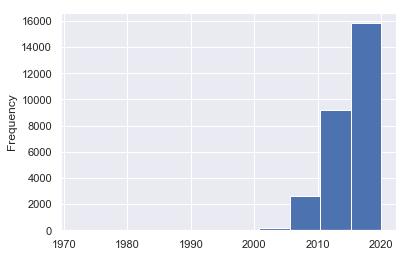

In [108]:
dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date) & 
                      (dedup_combined_df.topic == 'cc')].year.plot.hist()

In [112]:
top_pro_domains = set(dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date) & 
                      (dedup_combined_df.topic == 'cc') & 
                                     (dedup_combined_df.stance == 'pro')].\
pretty_domain.value_counts().index[:7])
top_anti_domains = set(dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date) & 
                      (dedup_combined_df.topic == 'cc') & 
                                     (dedup_combined_df.stance == 'anti')].\
pretty_domain.value_counts().index[:7])

In [113]:
top_pro_domains,top_anti_domains

({'Buzzfeed',
  'Guardian (US)',
  'Mother Jones',
  'New York Times',
  'The Nation',
  'Vox',
  'Washington Post'},
 {'Blaze',
  'Breitbart',
  'Christian Science Monitor',
  'Daily Caller',
  'Fox',
  'National Review',
  'PJ Media'})

In [209]:
top_pro_vax_domains = set(dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date) & 
                      (dedup_combined_df.topic == 'vax') & 
                                     (dedup_combined_df.stance == 'pro') & 
                                               (~dedup_combined_df.domain.isin(['fox',
                                                                              'nyt',
                                                                              'breitbart']))].\
pretty_domain.value_counts().index[:7])
top_anti_vax_domains = set(dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date) & 
                      (dedup_combined_df.topic == 'vax') & 
                                     (dedup_combined_df.stance == 'anti')].\
pretty_domain.value_counts().index[:7])

In [212]:
top_pro_vax_domains,top_anti_vax_domains

({'Adult Vaccines Now',
  'Immunization Evidence',
  'Shot of Prevention',
  'Voices for Vaccines'},
 {"Children's Health Defense",
  'Citizens',
  'Physicians for Informed Consent',
  'Vax Safety Commission'})

In [183]:
df = pd.DataFrame(columns=['outlet']+list(range(2007,2020)))
for outlet in top_pro_domains:
    #print(outlet)
    row = [outlet]
    counts = dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date) & 
                      (dedup_combined_df.topic == 'cc') & 
                         (dedup_combined_df.pretty_domain == outlet)].year.value_counts()
    row.extend([counts[int(c)] if c in counts else 0 for c in range(2007,2020)])
    row_df = pd.DataFrame(row).T
    row_df.columns = df.columns
    df = df.append(row_df,
                   ignore_index=True)
row = ['other']
counts = dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date) & 
                      (dedup_combined_df.topic == 'cc') & 
                               (dedup_combined_df.stance == 'pro') & 
                         (~dedup_combined_df.pretty_domain.isin(top_pro_domains))].year.value_counts()
row.extend([counts[int(c)] if c in counts else 0 for c in range(2007,2020)])
row_df = pd.DataFrame(row).T
row_df.columns = df.columns
df_pro = df.append(row_df,
               ignore_index=True)
df_pro

,outlet,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Washington Post,7,5,12,11,31,57,84,123,128,151,176,233,365
1,Mother Jones,45,76,128,122,90,147,226,265,264,267,368,437,318
2,Guardian (US),25,63,95,109,197,223,244,196,16,34,33,99,237
3,Buzzfeed,1,1,1,0,5,21,32,27,102,74,153,117,158
4,New York Times,75,42,63,334,300,303,167,278,480,620,811,961,1046
5,Vox,0,0,0,0,0,0,0,101,199,123,168,127,235
6,The Nation,30,12,63,48,93,83,130,153,153,167,125,110,114
7,other,34,21,43,51,52,66,240,418,225,242,284,264,377


In [184]:
df = pd.DataFrame(columns=['outlet']+list(range(2007,2020)))
for outlet in top_anti_domains:
    #print(outlet)
    row = [outlet]
    counts = dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date) & 
                      (dedup_combined_df.topic == 'cc') & 
                         (dedup_combined_df.pretty_domain == outlet)].year.value_counts()
    row.extend([counts[int(c)] if c in counts else 0 for c in range(2007,2020)])
    row_df = pd.DataFrame(row).T
    row_df.columns = df.columns
    df = df.append(row_df,
                   ignore_index=True)
row = ['other']
counts = dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date) & 
                      (dedup_combined_df.topic == 'cc') & 
                               (dedup_combined_df.stance == 'anti') & 
                         (~dedup_combined_df.pretty_domain.isin(top_anti_domains))].year.value_counts()
row.extend([counts[int(c)] if c in counts else 0 for c in range(2007,2020)])
row_df = pd.DataFrame(row).T
row_df.columns = df.columns
df_anti = df.append(row_df,
               ignore_index=True)
df_anti

,outlet,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,National Review,9,9,19,19,26,17,53,78,54,38,54,42,77
1,Breitbart,0,0,11,39,26,17,59,236,268,159,228,246,730
2,Daily Caller,0,0,0,1,4,4,27,71,158,252,184,116,55
3,Christian Science Monitor,22,317,188,164,65,142,337,265,280,283,100,40,10
4,Fox,15,19,26,41,26,41,87,100,107,63,184,294,283
5,PJ Media,0,0,0,0,0,2,9,6,7,8,15,9,344
6,Blaze,0,0,0,7,34,54,53,56,86,49,104,40,112
7,other,6,15,20,27,64,85,81,108,108,72,72,107,409


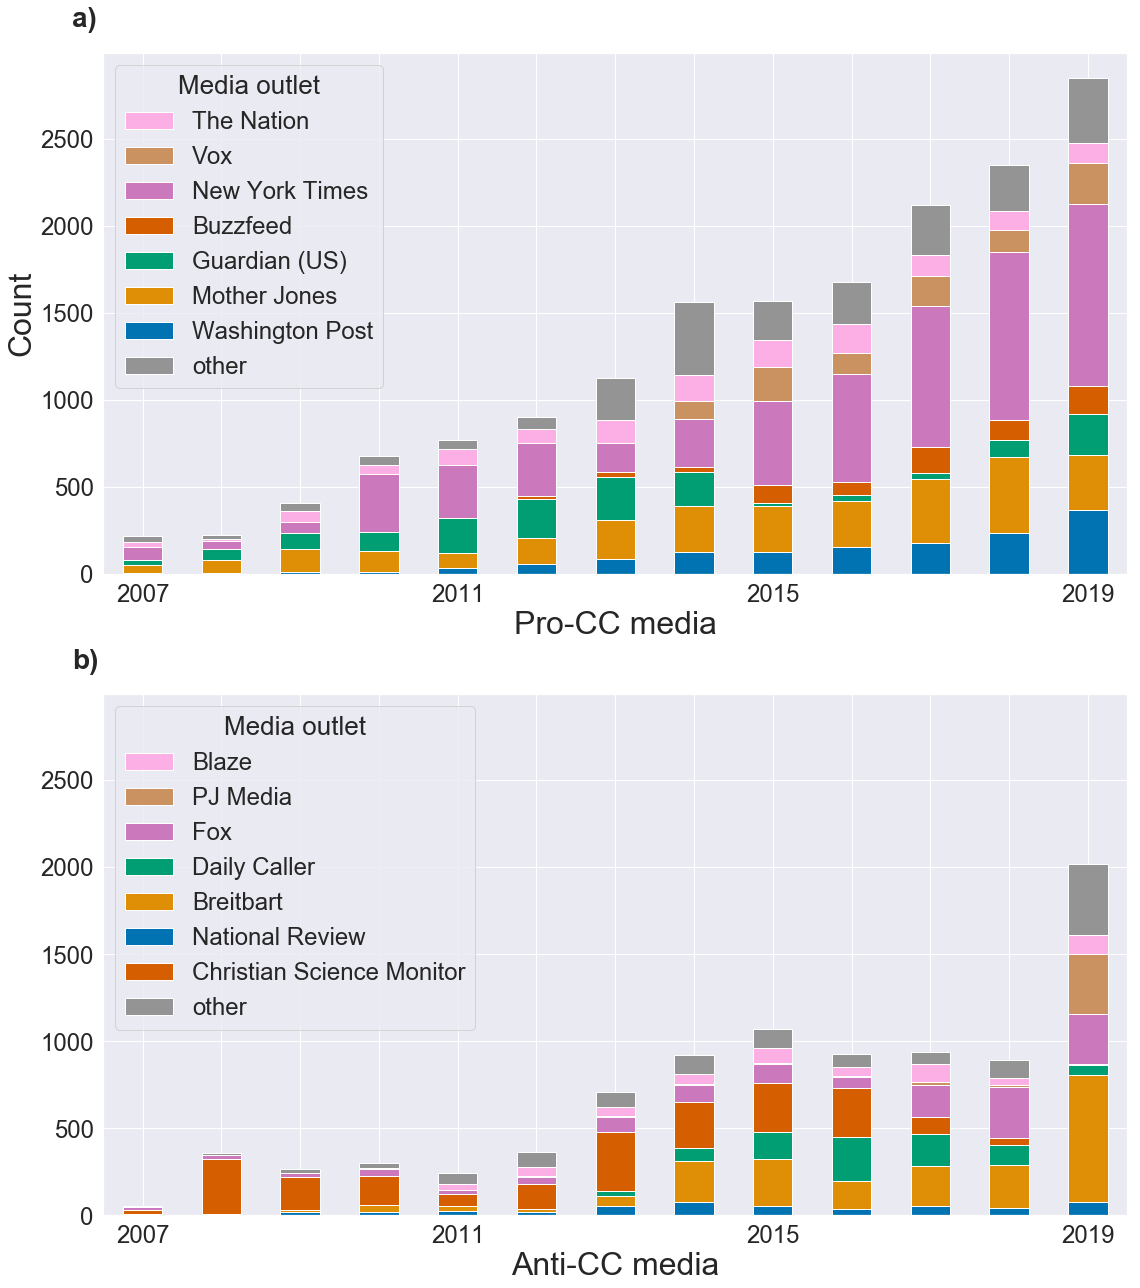

In [202]:
sns.set_palette('colorblind')
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,18),sharey=True)
df_pro.set_index('outlet').T.plot(kind='bar', stacked=True, fontsize=24,ax=ax1)
df_anti.set_index('outlet').T.plot(kind='bar', stacked=True, fontsize=24,ax=ax2)
ax1.set_ylabel('Count',fontsize=32)
ax2.set_ylabel('')
ax1.set_xlabel('Pro-CC media',fontsize=32)
ax2.set_xlabel('Anti-CC media',fontsize=32)
ax1.set_xticklabels(rotation=0,labels=range(2007,2020))
ax2.set_xticklabels(rotation=0,labels=range(2007,2020))
n = 4
for ax in [ax1,ax2]:
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax1.legend()
handles, labels = ax1.get_legend_handles_labels()
reorderLegend(ax1,['The Nation','Vox','New York Times','Buzzfeed',
                'Guardian (US)','Mother Jones','Washington Post','other'],
             title='Media outlet',fontsize=24,title_fontsize=26)
ax2.legend()
handles, labels = ax2.get_legend_handles_labels()
reorderLegend(ax2,['National Review','Blaze',
'PJ Media','Fox',
'Daily Caller','Breitbart','National Review','Christian Science Monitor','other'],
             title='Media outlet',fontsize=24,title_fontsize=26)

for n, ax in enumerate([ax1,ax2]):  
    ax.text(-0.03, 1.05, '{})'.format(string.ascii_lowercase[n]), transform=ax.transAxes, 
            size=28, weight='bold')
plt.tight_layout()

In [223]:
df = pd.DataFrame(columns=['outlet']+list(range(2007,2021)))
for outlet in top_pro_vax_domains:
    #print(outlet)
    row = [outlet]
    counts = dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date) & 
                      (dedup_combined_df.topic == 'vax') & 
                         (dedup_combined_df.pretty_domain == outlet)].year.value_counts()
    #print(counts)
    row.extend([counts[int(c)] if c in counts else 0 for c in range(2007,2021)])
    #print(row)
    row_df = pd.DataFrame(row).T
    row_df.columns = df.columns
    df = df.append(row_df,
                   ignore_index=True)
# row = ['other']
# counts = dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date) & 
#                       (dedup_combined_df.topic == 'vax') & 
#                                (dedup_combined_df.stance == 'pro') & 
#                          (~dedup_combined_df.pretty_domain.isin(top_pro_vax_domains))].year.value_counts()
# row.extend([counts[int(c)] if c in counts else 0 for c in range(2007,2021)])
# row_df = pd.DataFrame(row).T
# row_df.columns = df.columns
# df_pro = df.append(row_df,
#                ignore_index=True)
df_pro = df
df_pro

,outlet,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Adult Vaccines Now,0,0,0,0,0,0,0,0,0,0,0,0,0,39
1,Immunization Evidence,0,0,0,0,0,0,0,0,0,0,0,0,0,13
2,Voices for Vaccines,0,0,0,0,0,0,0,0,0,0,0,0,0,187
3,Shot of Prevention,0,0,0,0,0,0,0,0,0,0,0,0,0,718


In [224]:
df = pd.DataFrame(columns=['outlet']+list(range(2007,2021)))
for outlet in top_anti_vax_domains:
    #print(outlet)
    row = [outlet]
    counts = dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date) & 
                      (dedup_combined_df.topic == 'vax') & 
                         (dedup_combined_df.pretty_domain == outlet)].year.value_counts()
    row.extend([counts[int(c)] if c in counts else 0 for c in range(2007,2021)])
    row_df = pd.DataFrame(row).T
    row_df.columns = df.columns
    df = df.append(row_df,
                   ignore_index=True)
row = ['other']
counts = dedup_combined_df.loc[~pd.isnull(dedup_combined_df.date) & 
                      (dedup_combined_df.topic == 'vax') & 
                               (dedup_combined_df.stance == 'anti') & 
                         (~dedup_combined_df.pretty_domain.isin(top_anti_vax_domains))].year.value_counts()
row.extend([counts[int(c)] if c in counts else 0 for c in range(2007,2021)])
row_df = pd.DataFrame(row).T
row_df.columns = df.columns
df_anti = df.append(row_df,
               ignore_index=True)
df_anti

,outlet,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Physicians for Informed Consent,0,0,0,0,0,0,0,0,0,0,0,0,4,0
1,Citizens,0,0,34,5,2,0,0,0,2,1,1,1,0,0
2,Children's Health Defense,0,0,0,0,1,0,0,1,2,5,31,54,77,285
3,Vax Safety Commission,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,other,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [232]:
(285+77+187+718+13+39)/(1319+34+5+2+4+2+3+4+5+31+54)

0.9015721120984279

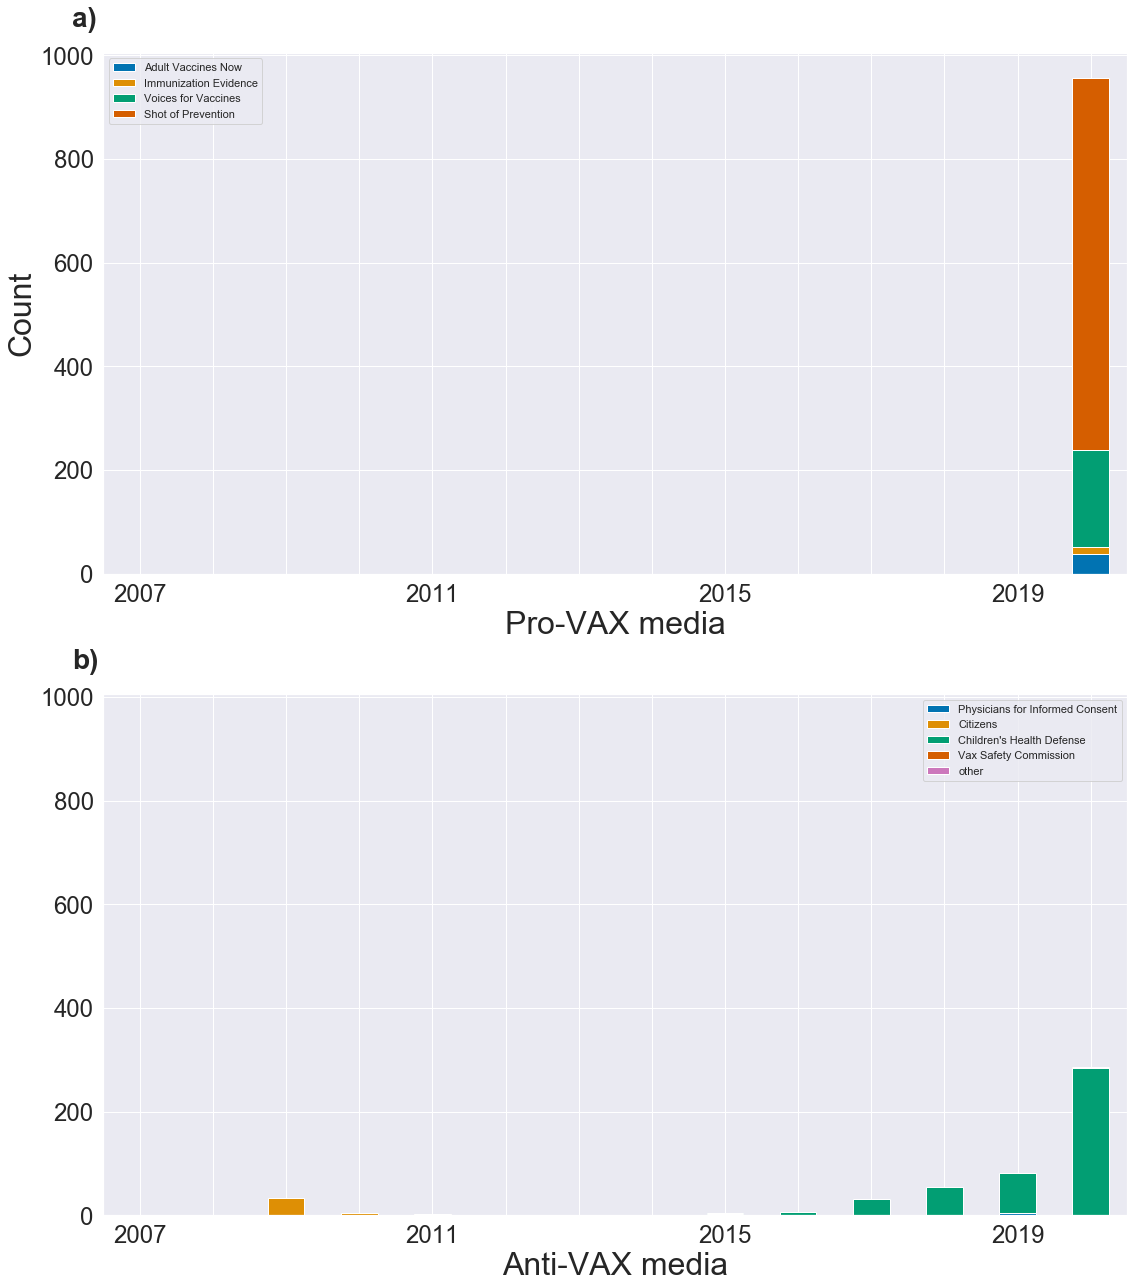

In [225]:
sns.set_palette('colorblind')
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,18),sharey=True)
df_pro.set_index('outlet').T.plot(kind='bar', stacked=True, fontsize=24,ax=ax1)
df_anti.set_index('outlet').T.plot(kind='bar', stacked=True, fontsize=24,ax=ax2)
ax1.set_ylabel('Count',fontsize=32)
ax2.set_ylabel('')
ax1.set_xlabel('Pro-VAX media',fontsize=32)
ax2.set_xlabel('Anti-VAX media',fontsize=32)
ax1.set_xticklabels(rotation=0,labels=range(2007,2020))
ax2.set_xticklabels(rotation=0,labels=range(2007,2020))
n = 4
for ax in [ax1,ax2]:
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax1.legend()
handles, labels = ax1.get_legend_handles_labels()
# reorderLegend(ax1,['The Nation','Vox','New York Times','Buzzfeed',
#                 'Guardian (US)','Mother Jones','Washington Post','other'],
#              title='Media outlet',fontsize=24,title_fontsize=26)
ax2.legend()
handles, labels = ax2.get_legend_handles_labels()
# reorderLegend(ax2,['National Review','Blaze',
# 'PJ Media','Fox',
# 'Daily Caller','Breitbart','National Review','Christian Science Monitor','other'],
#              title='Media outlet',fontsize=24,title_fontsize=26)

for n, ax in enumerate([ax1,ax2]):  
    ax.text(-0.03, 1.05, '{})'.format(string.ascii_lowercase[n]), transform=ax.transAxes, 
            size=28, weight='bold')
plt.tight_layout()

((<BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>),
 ('Blaze',
  'PJ Media',
  'Fox',
  'Daily Caller',
  'Breitbart',
  'National Review',
  'Christian Science Monitor',
  'other'))

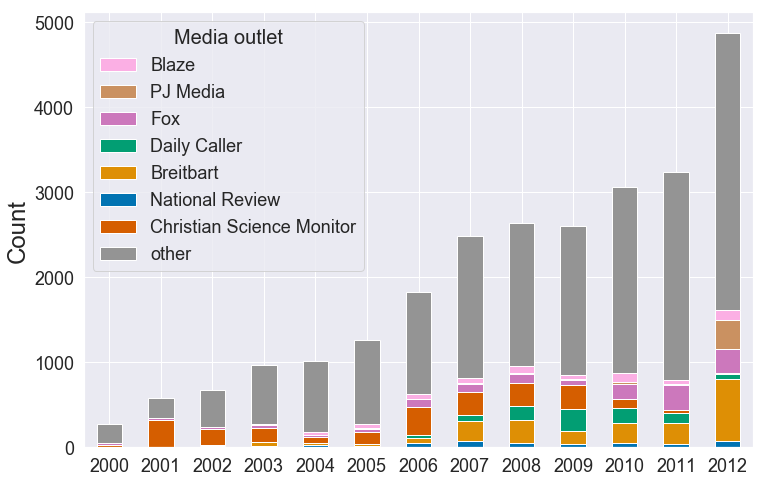

In [181]:
ax = df_anti.set_index('outlet').T.plot(kind='bar', stacked=True, figsize=(12,8),fontsize=18)
ax.set_ylabel('Count',fontsize=24)
ax.set_xticklabels(rotation=0,labels=range(2000,2020))
ax.legend()
handles, labels = ax.get_legend_handles_labels()
reorderLegend(ax,['National Review','Blaze',
'PJ Media','Fox',
'Daily Caller','Breitbart','National Review','Christian Science Monitor','other'],
             title='Media outlet')

((<BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>,
  <BarContainer object of 13 artists>),
 ('The Nation',
  'Vox',
  'New York Times',
  'Buzzfeed',
  'Guardian (US)',
  'Mother Jones',
  'Washington Post',
  'other'))

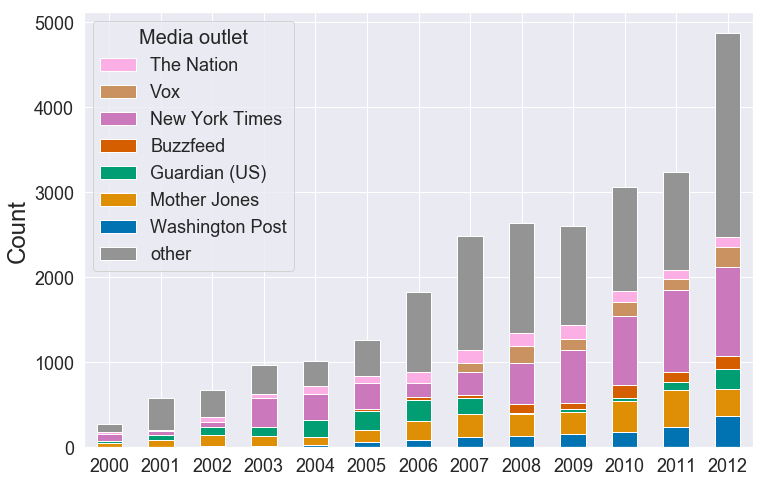

In [182]:
ax = df_pro.set_index('outlet').T.plot(kind='bar', stacked=True, figsize=(12,8),fontsize=18)
ax.set_ylabel('Count',fontsize=24)
ax.set_xticklabels(rotation=0,labels=range(2000,2020))
ax.legend()
handles, labels = ax.get_legend_handles_labels()
reorderLegend(ax,['The Nation','Vox','New York Times','Buzzfeed',
                'Guardian (US)','Mother Jones','Washington Post','other'],
             title='Media outlet')

## Distribution over media outlets

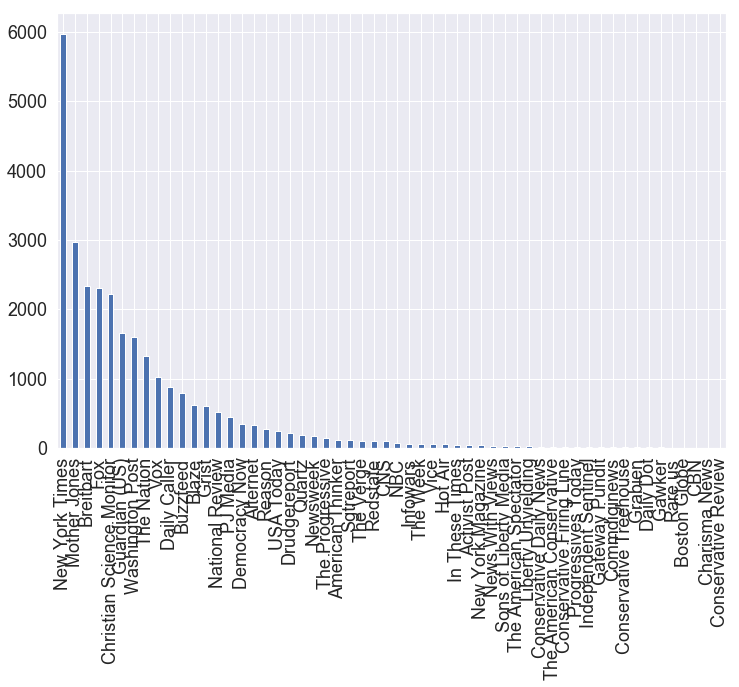

In [118]:
%matplotlib inline
dedup_combined_df.loc[dedup_combined_df.topic == 'cc'].pretty_domain.value_counts()\
.plot.bar(figsize=(12,8),fontsize=18)

In [227]:
len(dedup_combined_df.loc[dedup_combined_df.topic == 'cc'].pretty_domain.value_counts()\
    .index)

56

In [242]:
len(dedup_combined_df.loc[(dedup_combined_df.topic == 'cc') & 
                     (dedup_combined_df.stance == 'pro')].pretty_domain.value_counts().index)

23

In [243]:
len(dedup_combined_df.loc[(dedup_combined_df.topic == 'cc') & 
                     (dedup_combined_df.stance == 'anti')].pretty_domain.value_counts().index)

33

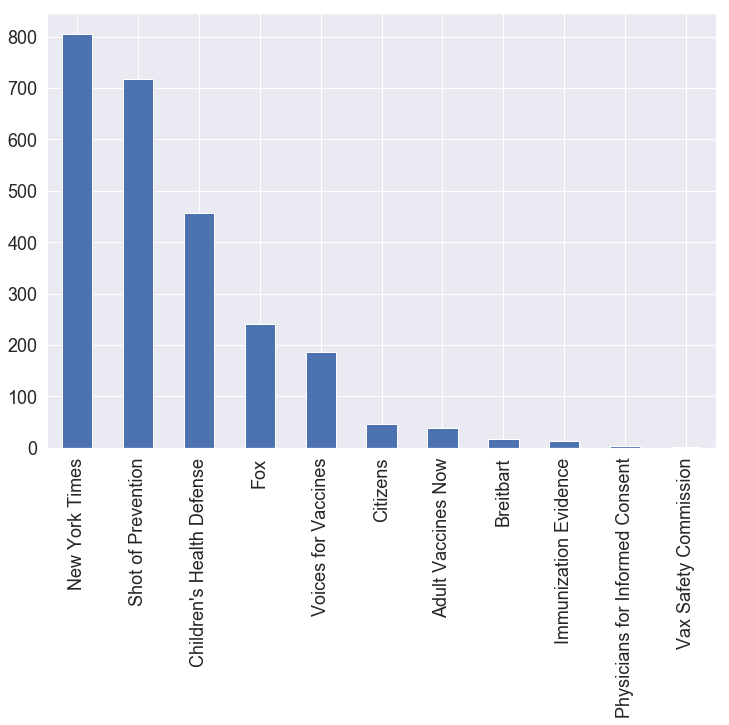

In [119]:
dedup_combined_df.loc[dedup_combined_df.topic == 'vax'].pretty_domain.value_counts()\
.plot.bar(figsize=(12,8),fontsize=18)

In [228]:
len(dedup_combined_df.loc[dedup_combined_df.topic == 'vax'].pretty_domain.value_counts()\
    .index)

11

In [230]:
dedup_combined_df.loc[dedup_combined_df.topic == 'vax'].pretty_domain.value_counts()

New York Times                     806
Shot of Prevention                 718
Children's Health Defense          457
Fox                                241
Voices for Vaccines                187
Citizens                            47
Adult Vaccines Now                  39
Breitbart                           17
Immunization Evidence               13
Physicians for Informed Consent      4
Vax Safety Commission                1
Name: pretty_domain, dtype: int64